Loading dependencies

In [1]:
%matplotlib notebook
import datetime
import obspy
from obspy.clients.fdsn import Client
from imp import reload
import warnings
warnings.filterwarnings('ignore')

This will add necessary method to obspy objects

In [2]:
import sys
sys.path.append("/Users/massin/Google Drive/Projects/NaiNo-Kami/Py/obspy_addons")
import obspy_addons
reload(obspy_addons)
obspy.core.event.catalog.Catalog.plot_eventsections = obspy_addons.plot_eventsections
obspy.core.inventory.Inventory.hasdata = obspy_addons.hasdata
obspy.core.event.catalog.Catalog.evfind = obspy_addons.evfind
obspy.core.event.catalog.Catalog.plot_Mfirst = obspy_addons.plot_Mfirst
obspy.core.event.catalog.Catalog.plot_eew = obspy_addons.plot_eew

In [32]:
import matplotlib
import matplotlib.patheffects
import numpy
from math import radians, cos, sin, asin, sqrt
def plot_Mfirst(self=obspy.core.event.catalog.Catalog()):
    mags =          [e.magnitudes[-1].mag                        for e in self.events ]
    profs =         [e.origins[-1].depth/1000.                   for e in self.events ]
    mags_stations = [e.magnitudes[-1].station_count              for e in self.events ]
    m1_errors =     [e.magnitudes[-1].mag-e.magnitudes[0].mag    for e in self.events ]
    m1_types =      [e.magnitudes[0].magnitude_type              for e in self.events ]
    m1_times =      [e.magnitudes[0].creation_info.creation_time for e in self.events ]
    m1_origint =    [e.origins[-1].time                          for e in self.events ]
    m1_delays = numpy.asarray(m1_times)-numpy.asarray(m1_origint)
    
    if len(mags) >0:
        f, (ax) = matplotlib.pyplot.subplots(1, 1)
        matplotlib.pyplot.ylabel('Error in first M')
        matplotlib.pyplot.xlabel('Reference M')
        matplotlib.pyplot.title('First M, with delays')
        matplotlib.pyplot.grid()

        for m in [min(mags_stations),numpy.median(mags_stations),max(mags_stations)]:
            sc = ax.scatter(numpy.mean(mags), 0, 
                            (m-min(mags_stations)+1)/(max(mags_stations)-min(mags_stations))*500, 
                            'w', 'o', label=str(int(m))+' stat.',alpha=0.7 )

        ax.axhline(0, linestyle='--', color='k') # horizontal lines

        if len(m1_delays)<64:
            for i, txt in enumerate(m1_delays):
                ax.text(mags[i], m1_errors[i], str(int(txt))+'s', weight="heavy",
                        color="k", zorder=100,
                        path_effects=[
                            matplotlib.patheffects.withStroke(linewidth=3,
                                                   foreground="white")])
        types = ['M*','MLv','MVS']
        for i,m in enumerate(['+','^','o']):
            matches = [ j for j,t in enumerate(m1_types) if t == types[i] ]
            if matches:
                sc = ax.scatter([mags[j] for j in matches] , 
                                [m1_errors[j] for j in matches] , 
                                [(mags_stations[j]-min(mags_stations)+1)/(max(mags_stations)-min(mags_stations))*500 for j in matches] ,
                                [profs[j] for j in matches], 
                                m, 
                                norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=numpy.max(profs)),
                                label=types[i],alpha=0.5,zorder=150,edgecolors='k')
        cb=matplotlib.pyplot.colorbar(sc)
        cb.set_label('Reference depth (km)')
        lg = matplotlib.pyplot.legend()
        lg.set_title('Marker & Sizes')
        lg.get_frame().set_alpha(0.1)
        lg.get_frame().set_color('k')
        matplotlib.pyplot.axis('equal')
        print(self)

def plot_eew(self=obspy.core.event.catalog.Catalog()):
    mags =          [e.magnitudes[-1].mag                        for e in self.events ]
    profs =         [e.origins[-1].depth/1000.                   for e in self.events ]
    mags_stations = [e.magnitudes[-1].station_count              for e in self.events ]
    m1_errors =     [e.magnitudes[-1].mag-e.magnitudes[0].mag    for e in self.events ]
    m1_types =      [e.magnitudes[0].magnitude_type              for e in self.events ]
    m1_times =      [e.magnitudes[0].creation_info.creation_time for e in self.events ]
    m1_origint =    [e.origins[-1].time                          for e in self.events ]
    m1_delays = numpy.asarray(m1_times)-numpy.asarray(m1_origint)
    
    if len(mags) >0:
        f, (ax1,ax2) = matplotlib.pyplot.subplots(2, 1, sharex=True)
        ax1.set_ylabel('Error in location (km)')
        ax2.set_ylabel('Error in magnitude')
        ax1.set_xlabel('Time after origins (s)')
        ax2.set_xlabel('Time after origins (s)')
        ax2.set_xscale('log')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.xaxis.set_label_position('top') 
        ax1.xaxis.set_ticks_position('top') 
        ax1.grid()
        ax2.grid()


        dmins=[]
        for e in self.events:
            for o in e.origins:
                if len(o.arrivals)>0:
                    dmins.append(numpy.min([a.distance for a in o.arrivals]))


        for e in self.events:

            el =  [numpy.sqrt(haversine(e.origins[-1].longitude,e.origins[-1].latitude,o.longitude,o.latitude)**2+(e.origins[-1].depth-o.depth)**2)/1000 for o in e.origins]
            dtl = [o.creation_info.creation_time-e.origins[-1].time for o in e.origins]   

            picks = e.picks.copy()
            plist = []
            for i,o in reversed(list(enumerate(e.origins))):
                picks_creationtime = []
                picks_time = []
                picks_el = []
                if i<len(e.origins):
                    for a in o.arrivals:                 
                        if a.time_weight < 4 : #abs(a.time_residual)<(a.distance)/5./3:
                            for p in picks:
                                if a.pick_id == p.resource_id and p.time-e.origins[-1].time > .5 and p.time not in plist and p.time>e.origins[-1].time:
                                    picks_time.append(p.time-e.origins[-1].time)
                                    picks_creationtime.append(p.creation_info.creation_time-e.origins[-1].time)
                                    picks_el.append(el[i])
                                    picks.remove(p)
                                    plist.append(p.time)
                                    break
                    if False:#len(picks_time)>1:
                        ax1.scatter(picks_time,picks_el,10,
                                    numpy.repeat(e.magnitudes[-1].mag,len(picks_el)),#marker='+',
                                    norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                                    zorder=-99,alpha=0.3, edgecolors='none')


            ax1.scatter(dtl[:-1],el[:-1],10,marker='o',edgecolors='k') 
            sc1 = ax1.scatter(dtl[:-1],el[:-1],10,
                        numpy.repeat(e.magnitudes[-1].mag,len(dtl)-1),marker='o',
                        norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                        label=e.short_str(),linewidths=0,zorder=999)


            em =  [e.magnitudes[-1].mag-m.mag           for m in e.magnitudes]
            dtm = [m.creation_info.creation_time-e.origins[-1].time for m in e.magnitudes]

            ax2.scatter(dtm[:-1],em[:-1],10,marker='o',edgecolors='k')      
            sc2 = ax2.scatter(dtm[:-1],em[:-1],10,
                        numpy.repeat(e.magnitudes[-1].mag,len(dtm)-1),marker='o',
                        norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                        label=e.short_str(),linewidths=0,zorder=999)  

        cb=matplotlib.pyplot.colorbar(sc1, ax=[ax1,ax2])
        cb.set_label('Reference magnitude')
        ob2 = ax2.scatter(20,0,10,marker='o',alpha=0.1,color='b', edgecolors='none',zorder=-999)
        ob1 = ax2.scatter(20,0,10,marker='o',color='b',edgecolors='k',zorder=-999)
        ax2.scatter(20,0,10,marker='o',color='w',edgecolors='w',linewidths=3,zorder=-99)
        lg = matplotlib.pyplot.legend((ob1, ob2), ('Solutions (loc. or M)', 'Picks (t or A)'))

def evfind(self=obspy.core.event.catalog.Catalog(),tofind=obspy.core.event.catalog.Catalog(),v=False,x=True):
    
    matchs = obspy.core.event.catalog.Catalog()
    extras = obspy.core.event.catalog.Catalog()
    matchs.description = 'Intersections of '+str(self.description)+' and '+str(tofind.description)
    missed = obspy.core.event.catalog.Catalog()
    missed.description = 'Part of '+str(self.description)+' not in '+str(tofind.description)
    
    for e in tofind.events:
        o = e.preferred_origin() or e.origins[-1]
        found=False     
        if v:
            print('---- event',e.short_str(),'...')
        for ref in self.events: 
            refo = ref.preferred_origin() or ref.origins[-1]
            if abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)<=.5 and abs(o.longitude-refo.longitude)<=.5: 
                found=True  
                if v:
                    print('fits input catalog ',tofind.description,':\n  ', ref.short_str())                
                matchs.events.append(ref)
            
            elif abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)<1 and abs(o.longitude-refo.longitude)<1: 
                found=True  
                if v:
                    print('poorly fits input catalog ',tofind.description,':\n  ', ref.short_str())                
                matchs.events.append(ref)
                
        if not found:
            if v:
                print('does not exist in current catalog')            
            missed.events.append(e)
    if x :
        matchs_otherversion, extras, trash = tofind.evfind(self,v=v,x=False)
    return matchs, missed, extras

def hasdata(self,data=obspy.core.stream.Stream()):
    inv_ok = obspy.core.inventory.Inventory(networks=[],source=[])
    inv_dead = obspy.core.inventory.Inventory(networks=[],source=[])
    l = []
    ld = []
    for t in data.traces:
        if t.stats.network+t.stats.station not in l:
            toadd = self.select(network=t.stats.network,station=t.stats.station)
            if len(toadd.networks) >0:
                found = False
                for n in inv_ok.networks:
                    if n.code == t.stats.network:
                        n.stations.append(toadd.networks[0].stations[0])
                        found = True
                if not found:
                    inv_ok.__iadd__(toadd)
                l.append(t.stats.network+t.stats.station)
        for n in self.networks:
            for s in n.stations:
                code = str(n.code)+str(s.code)
                if code not in l and code not in ld:
                    toadd = self.select(network=str(n.code),station=str(s.code))
                    if len(toadd.networks) > 0:
                        found = False
                        for nd in inv_dead.networks:
                            if str(nd.code) == str(n.code):
                                nd.stations.append(toadd.networks[0].stations[0])
                                found = True
                        if not found:
                            inv_dead.__iadd__(toadd)
                        ld.append(code)
                    
    return inv_ok, inv_dead

def plot_eventsections(self, client_wf, afterpick = 30):
        
    for e in self:
        
        pmax = max([p.time for p in e.picks])
        
        picks = []
        arrivals = [] 
        st = obspy.core.stream.Stream()
        o = e.preferred_origin() or e.origins[-1]
        for p in e.picks:
            try:
                toadd = client_wf.get_waveforms(p.waveform_id.network_code,
                                                p.waveform_id.station_code,
                                                p.waveform_id.location_code,
                                                p.waveform_id.channel_code,
                                                starttime = o.time,
                                                endtime = pmax+afterpick )
            except:
                toadd = obspy.core.stream.Stream()
                
            for t in toadd:
                found=False
                for a in o.arrivals:
                    if a.pick_id == p.resource_id:
                        t.stats.distance = a.distance*11000.   
                        picks.append(p)
                        arrivals.append(a)
                        found=True
                if not found:
                    toadd.remove(t)
                    
            st += toadd
        if len(st)>0:
            st.detrend()
            tmp=st.slice(starttime=o.time, endtime=pmax+afterpick ) 
            tmp.merge(method=1)
            
            fig = matplotlib.pyplot.figure()
            tmp.plot(type='section', # starttime=o.time-10,
                     reftime=o.time,
                     time_down=True,
                     linewidth=.25,
                     grid_linewidth=.25,                  
                     show=False, 
                     fig=fig,
                     color='network')
            ax = matplotlib.pyplot.gca()
            transform = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
            transform_picks = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transData)
            for i,tr in enumerate(st):
                ax.text(tr.stats.distance / 1e3, 1.0, tr.stats.station, rotation=270,
                        va="bottom", ha="center", transform=transform, zorder=10)
                ax.plot(tr.stats.distance / 1e3,
                        picks[i].time - o.time, 
                        '+k',
                        transform=transform_picks,
                        zorder=10)
                ax.text(tr.stats.distance / 1e3,
                        picks[i].time - o.time,
                        str(picks[i].phase_hint), 
                        weight="heavy",
                        color="k", 
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        zorder=20,
                        path_effects=[matplotlib.patheffects.withStroke(linewidth=3,
                                                                        foreground="white")])

            l = ax.get_legend()    
            la = [ text.get_text() for text in l.get_texts()]
            [line.set_linewidth(3) for line in l.get_lines()]
            li = l.get_lines()
            l.remove()
            l = ax.legend(li,la,ncol=7,prop={'size':6},title=e.short_str()+' \n '+str(e.resource_id))
            l.get_title().set_fontsize('6')
            ax.set_ylabel('Time after origin [s]')

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371000 # Radius of earth in meters. Use 3956 for miles
    return c * r 

obspy.core.event.catalog.Catalog.plot_eventsections = plot_eventsections
obspy.core.inventory.Inventory.hasdata = hasdata
obspy.core.event.catalog.Catalog.evfind = evfind
obspy.core.event.catalog.Catalog.plot_Mfirst = plot_Mfirst
obspy.core.event.catalog.Catalog.plot_eew = plot_eew

Loading parameters

In [5]:
client_eew = Client('http://localhost:18080')
client_eq = Client('http://165.98.224.52:8081')
#client_wf = Client('http://165.98.224.59:8081')
client = Client('IRIS')

N=[0,3]
minM = 4.9
lon=[-95,-80]
lat=[10,15]
net='NU'
end = (datetime.datetime.now()-datetime.timedelta(days=N[0])).isoformat()
start = (datetime.datetime.now()-datetime.timedelta(days=sum(N))).isoformat()
endsample = (datetime.datetime.now()-datetime.timedelta(days=sum(N))+datetime.timedelta(seconds=1)).isoformat()

eq_specs = {'starttime':start,
            'endtime':end,
            'minlatitude':lat[0],
            'maxlatitude':lat[1],
            'minlongitude':lon[0],
            'maxlongitude':lon[1],
            'orderby':'magnitude-asc',
            'includearrivals':True}

lq_specs = {'starttime':start,
            'endtime':end,
            'minlatitude':lat[0]-1,
            'maxlatitude':lat[1]+1,
            'minlongitude':lon[0]-1,
            'maxlongitude':lon[1]+1,
            'orderby':'magnitude-asc',
            'includearrivals':True}

eew_specs = eq_specs.copy()
eew_specs['includeallorigins']=True
eew_specs['includeallmagnitudes']=True

sta_specs = {'starttime':start,
             'endtime':end,
             'minlatitude':lat[0],
             'maxlatitude':lat[1],
             'minlongitude':lon[0],
             'maxlongitude':lon[1],
             'level':'station'}

sta_eqspecs = {'starttime':start,
               'endtime':end,
               'level':'station'}

map_specs={'projection':'local','resolution':'i','color_per_network':True}

# ssh -N -L 18080:localhost:8080  sysop@165.98.224.44

# Review of the earthquake early warning system for the N days. 

In [6]:
print('N: %s' % str(N))
print('into area %s°N %s°E' % (str(lat), str(lon)))
print("from %s" % start )
print("  to %s" % end )
print('for network %s.' % net)

N: [0, 3]
into area [10, 15]°N [-95, -80]°E
from 2017-03-27T09:29:19.010290
  to 2017-03-30T09:29:19.010077
for network NU.


## INETER observations
### Available network

<IPython.core.display.Javascript object>


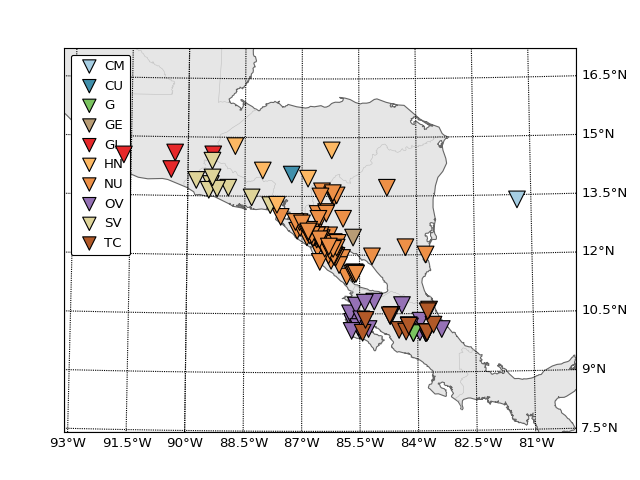

Inventory created at 2017-03-30T08:29:56.000000Z
	Sending institution: SeisComP3 (INETER)
	Contains:
		Networks (1):
			NU
		Stations (103):
			NU.AAHN (Alcaldia de Achuapa)
			NU.ABCN (SMA Banco Central, Nicaragua)
			NU.ACBN (SMA Campo Bello, Nicaragua)
			NU.ACON (Acoyapa, Nicaragua)
			NU.ACSN (SMA Ciudad Sandino, Nicaragua)
			NU.ADRN (SMA Diriamba, Nicaragua)
			NU.AERN (SMA Aeropuerto Managua, Nicaragua)
			NU.AESN (EL SAUCE LEON)
			NU.ALEN (SMA Leon, Nicaragua)
			NU.ALLN (SMA Telcor Managua, Nicaragua)
			NU.ALTN (Altagracia, Isla de ometepe)
			NU.AMTN (SMA Mateare, Nicaragua)
			NU.AMYN (SMA CODE Masaya, Nicaragua)
			NU.APQ2 (Apoyeque, Nicaragua)
			NU.APQ3 (Volcan Apoyeque sitio 3, Nicaragua)
			NU.APQ4 (Volcan Apoyeque sitio 4, Nicaragua)
			NU.APQ5 (Volcan Apoyeque sitio 5, Nicaragua)
			NU.APQN (BB Volcan Apoyeque, Nicaragua)
			NU.APYN (Volcan Apoyeque)
			NU.ARIN (SMA Rivas, Nicaragua)
			NU.AZCN (Norte del Volcan Masaya)
			NU.BC84 (SMA Volcan Momotombo, Nicaragua)


In [27]:
inventory = client_eq.get_stations( **sta_specs )
inventory.plot( **map_specs )
print( inventory.select( network = net ))

###  Network with data

<IPython.core.display.Javascript object>


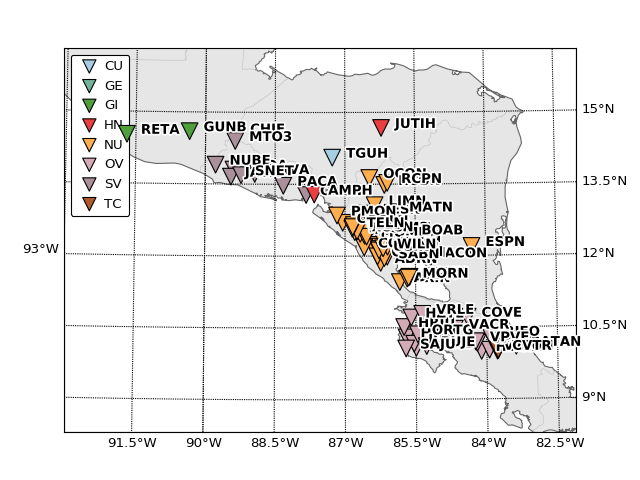

Inventory created at 2017-03-30T08:42:21.502658Z
	Created by: ObsPy 1.0.3
		    https://www.obspy.org
	Sending institution: SeisComP3 (INETER)
	Contains:
		Networks (1):
			NU
		Stations (49):
			NU.ABCN (SMA Banco Central, Nicaragua)
			NU.ACON (Acoyapa, Nicaragua)
			NU.ADRN (SMA Diriamba, Nicaragua)
			NU.AERN (SMA Aeropuerto Managua, Nicaragua)
			NU.AESN (EL SAUCE LEON)
			NU.ALLN (SMA Telcor Managua, Nicaragua)
			NU.AMTN (SMA Mateare, Nicaragua)
			NU.AMYN (SMA CODE Masaya, Nicaragua)
			NU.APQ2 (Apoyeque, Nicaragua)
			NU.ARIN (SMA Rivas, Nicaragua)
			NU.BC84 (SMA Volcan Momotombo, Nicaragua)
			NU.BC87 (SMA San Francisco Libre, Nicaragua)
			NU.CNGA (Al SSO del Volcan Cerro Negro)
			NU.CNGN (Volcan Cerro Negro, Nicaragua)
			NU.CONN (Central Sismica - INETER)
			NU.COPN (Copaltepe)
			NU.CRIN (volcan San Cristobal, Nicaragua)
			NU.CRUN (El Crucero)
			NU.DECN (SMA CODE-SINAPRED Managua, Nicaragua)
			NU.ENAN (SMA ENATREL Managua, Nicaragua)
			NU.ESPN (Las Esperanzas, Nicar

In [29]:
samples = client_eq.get_waveforms( '*', '*', '*', '*Z', start, endsample ) 
inventory_ok, inventory_dead = inventory.hasdata( samples ) 
inventory_ok.plot( **map_specs ) if len(inventory_ok.networks)>0 else None
print(inventory_ok.select( network=net ))
#inventory_dead.plot( **map_specs ) if len(inventory_ok.networks)>0 else None
#print(inventory_dead.select( network=net ))

### Observed earthquakes
In main earthquake authoritative location system, say **EAL**.

<IPython.core.display.Javascript object>


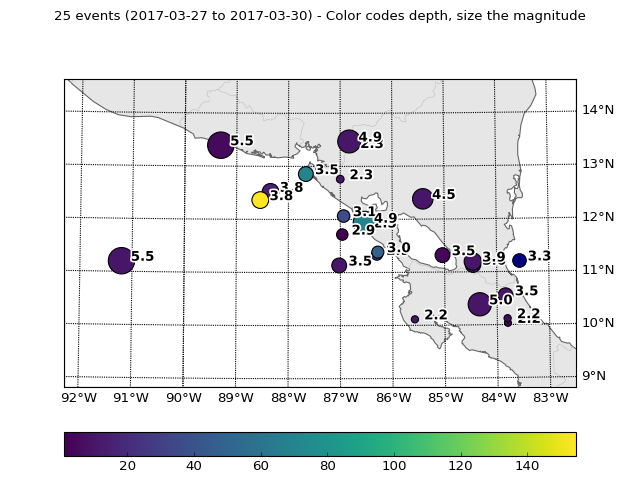

25 Event(s) in Catalog:
2017-03-28T06:04:02.082978Z | +10.030,  -83.797 | 2.15462928 M  | automatic
2017-03-28T05:28:04.128022Z | +10.118,  -83.803 | 2.198095031 M  | automatic
...
2017-03-28T19:23:44.277754Z | +11.198,  -91.202 | 5.523953623 M  | automatic
2017-03-28T16:14:15.826512Z | +13.393,  -89.310 | 5.536098189 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [8]:
cat = client_eq.get_events( **eq_specs )
cat.plot( **map_specs ) if len(cat)>0 else None
print( cat )

### The most important earthquakes

<IPython.core.display.Javascript object>


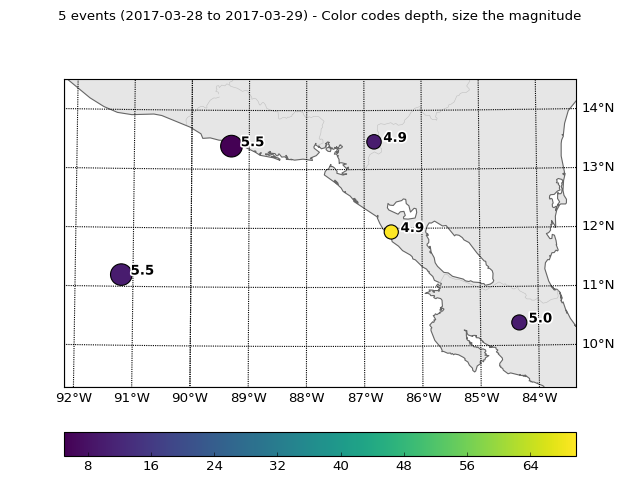

5 Event(s) in Catalog:
2017-03-29T16:59:08.174682Z | +11.939,  -86.532 | 4.894752817 M  | manual
2017-03-28T06:32:03.039664Z | +13.469,  -86.826 | 4.921719627 M  | automatic
2017-03-28T21:24:06.879920Z | +10.387,  -84.332 | 4.97561124 M  | automatic
2017-03-28T19:23:44.277754Z | +11.198,  -91.202 | 5.523953623 M  | automatic
2017-03-28T16:14:15.826512Z | +13.393,  -89.310 | 5.536098189 M  | automatic


In [9]:
subcat = cat.filter( "magnitude >= 4.5" )
subcat.plot( **map_specs )
print( subcat )

## Global observations

<IPython.core.display.Javascript object>


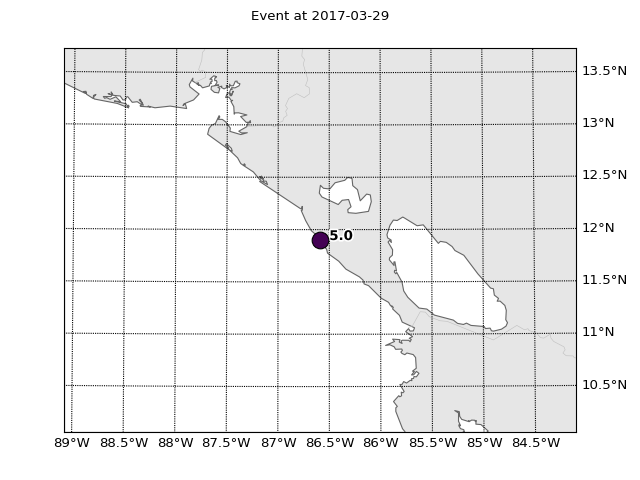

1 Event(s) in Catalog:
2017-03-29T16:59:08.860000Z | +11.901,  -86.591 | 5.0 mb


In [10]:
try:
    cat_glob = client.get_events( **lq_specs ) 
except:
    cat_glob = obspy.core.event.catalog.Catalog()
cat_glob.description = 'Global' if len(cat_glob)>0 else None
cat_glob.plot( **map_specs ) if len(cat_glob)>0 else None
print( cat_glob )

### Is something missing in EAL?

In [11]:
matchs, missed, extras = subcat.evfind( cat_glob )
missed.plot( **map_specs ) if len(missed)>0 else None
print(missed)

0 Event(s) in Catalog:



###  Review of missing earthquakes

In [12]:
print(['scolv -E '+str(e.resource_id) for e in missed ])
fig = missed.plot( **map_specs ) if len(missed)>0 else None
#missed.plot_eventsections(client_eq)    

[]


### Is there extra in EAL?

In [13]:
print(extras)
test = extras.events[0]

4 Event(s) in Catalog:
2017-03-28T06:32:03.039664Z | +13.469,  -86.826 | 4.921719627 M  | automatic
2017-03-28T21:24:06.879920Z | +10.387,  -84.332 | 4.97561124 M  | automatic
2017-03-28T19:23:44.277754Z | +11.198,  -91.202 | 5.523953623 M  | automatic
2017-03-28T16:14:15.826512Z | +13.393,  -89.310 | 5.536098189 M  | automatic


###  Review of extra in EAL

scolv -E smi:scs/0.7/ineterloc2017gbqf
scolv -E smi:scs/0.7/ineterloc2017gctq
scolv -E smi:scs/0.7/ineterloc2017gcpq
scolv -E smi:scs/0.7/ineterloc2017gcjk


<IPython.core.display.Javascript object>


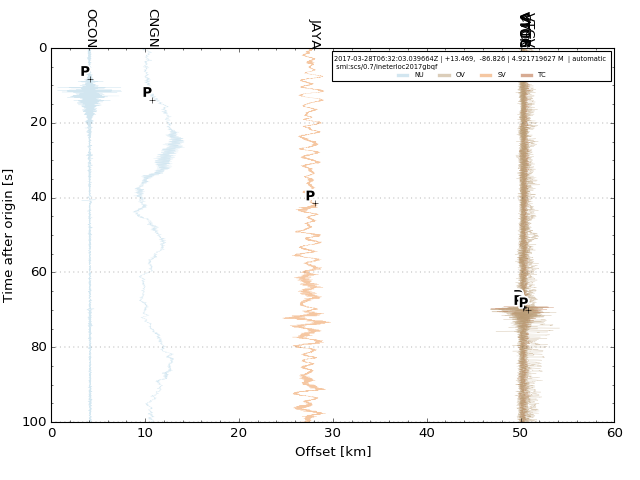

<IPython.core.display.Javascript object>


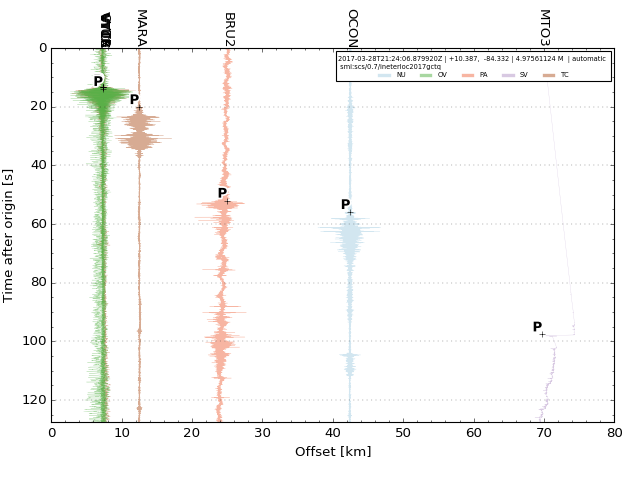

<IPython.core.display.Javascript object>


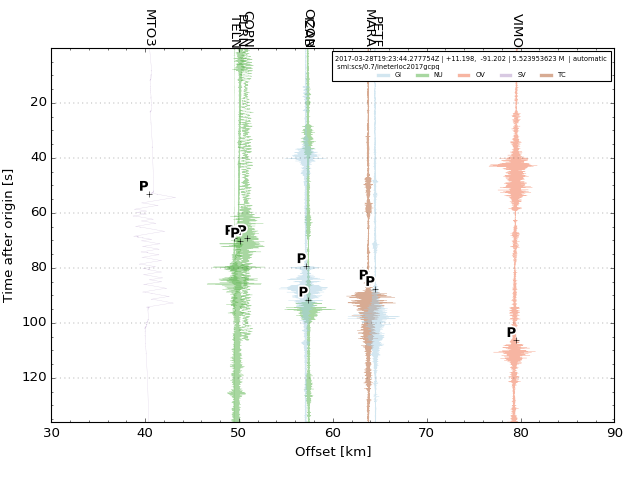

<IPython.core.display.Javascript object>


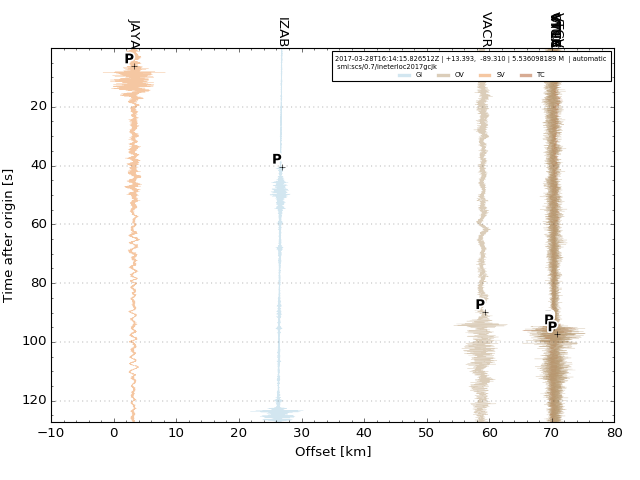

In [30]:
[print('scolv -E '+str(e.resource_id)) for e in extras ]
extras.plot_eventsections(client_eq)      

## Observations by INETER EEW

<IPython.core.display.Javascript object>


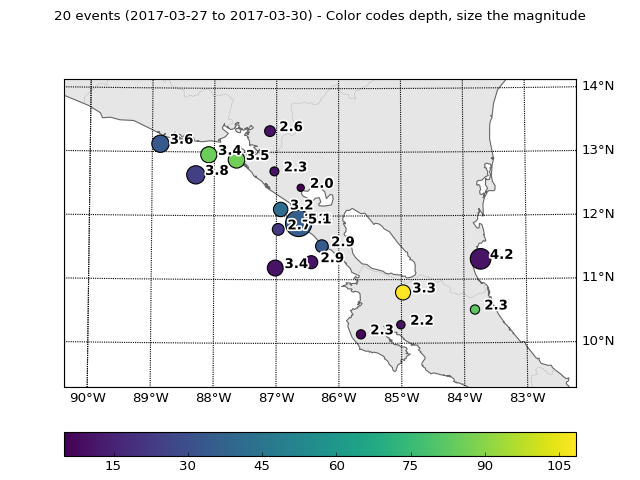

20 Event(s) in Catalog:
2017-03-27T15:50:59.707006Z | +12.443,  -86.611 | 1.96538066 M  | automatic
2017-03-29T17:55:16.172540Z | +10.291,  -85.011 | 2.1580732 M  | automatic
...
2017-03-29T03:49:00.990315Z | +11.317,  -83.730 | 4.191708748 M  | automatic
2017-03-29T16:59:09.938843Z | +11.884,  -86.643 | 5.135709594 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [14]:
eewcat = client_eew.get_events(**eew_specs)
fig = eewcat.plot(**map_specs)
print(eewcat)

### How consistent are EEW and main systems ?

In [21]:
missed_main = obspy.core.event.Catalog()
missed_eew = obspy.core.event.Catalog()
falses_eew = obspy.core.event.Catalog()
#falses_main = obspy.core.event.Catalog()
eewcat_checked = obspy.core.event.Catalog()

for e in eewcat.events:
    o = e.preferred_origin() or e.origins[-1]
    found=False 
    real=False
    
    for ref in cat.events: 
        refo = ref.preferred_origin() or ref.origins[-1]
        refm = ref.preferred_magnitude() or ref.magnitudes[-1] 
        if abs(o.time-refo.time) < 60: # These 2 match
            found=True  
            foundo = refo.copy()
            foundm = refm.copy()
            if refo.evaluation_mode != 'automatic' and refm.evaluation_mode != 'automatic' : # the ref eq is real
                real = True 
            if ref.event_type in ['earthquake', 'other event']:     # the ref eq is real
                real = True
            if e.event_type in ['earthquake', 'other event']:       # the eew eq is real
                real = True
    if not found:
        if not real: # misfit & fake
            falses_eew.append(e)
        else:        # misfit but real eq
            missed_main.append(e)
    else:
        if not real: # match & fake
            falses_eew.append(e)
        else:        # match & real eq (eew origins + ref origin)
            eewcat_checked.events.append(e)
            eewcat_checked.events[-1].origins.append(foundo)
            eewcat_checked.events[-1].magnitudes.append(foundm)            

### False alarms
Not identified as earthquakes.

<IPython.core.display.Javascript object>


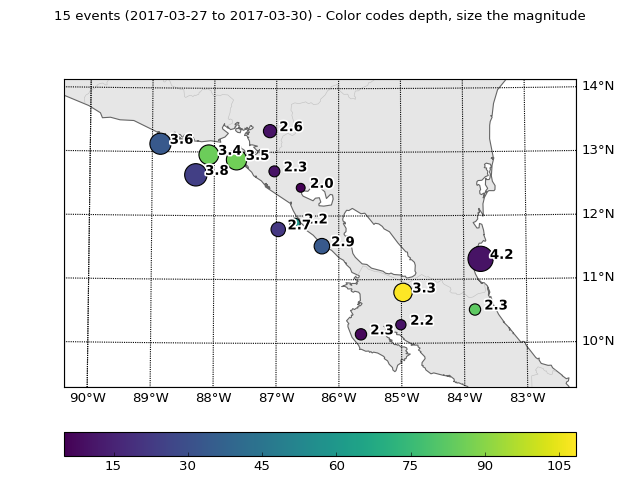

15 Event(s) in Catalog:
2017-03-27T15:50:59.707006Z | +12.443,  -86.611 | 1.96538066 M  | automatic
2017-03-29T17:55:16.172540Z | +10.291,  -85.011 | 2.1580732 M  | automatic
...
2017-03-27T20:00:01.682432Z | +12.640,  -88.298 | 3.800561396 M  | automatic
2017-03-29T03:49:00.990315Z | +11.317,  -83.730 | 4.191708748 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [22]:
fig = falses_eew.plot( **map_specs ) if len(falses_eew)>0 else None    
print(falses_eew)

###  Review of false alarms

scolv -E smi:ni.gob.ineter/sc-eew-1/2017gbgghw
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gfbvdz
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gedvcj
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gcgamh
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gaviqk
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gaxlhq
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gedcly
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gfwvrf
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gcfwhe
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gesiws
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gdfetr
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gfwdxu
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gclbxd
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gbomxu
scolv -E smi:ni.gob.ineter/sc-eew-1/2017gdztxw


<IPython.core.display.Javascript object>


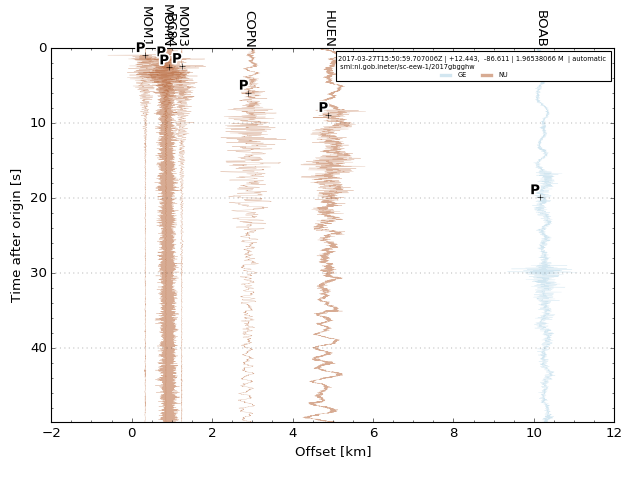

<IPython.core.display.Javascript object>


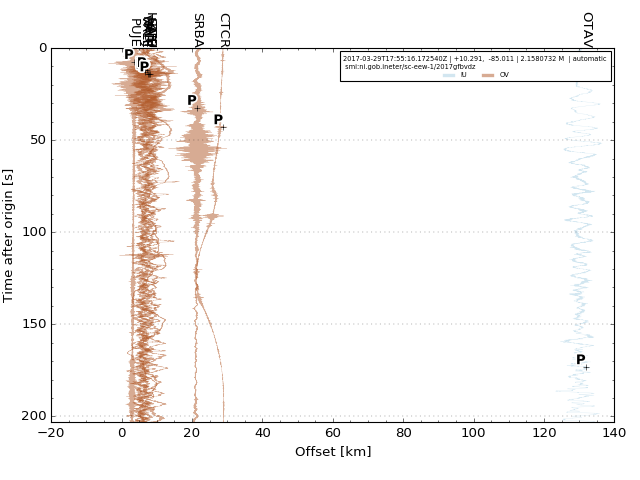

<IPython.core.display.Javascript object>


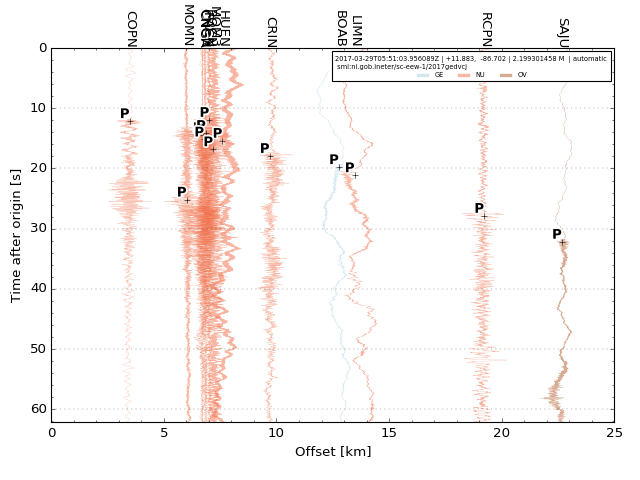

<IPython.core.display.Javascript object>


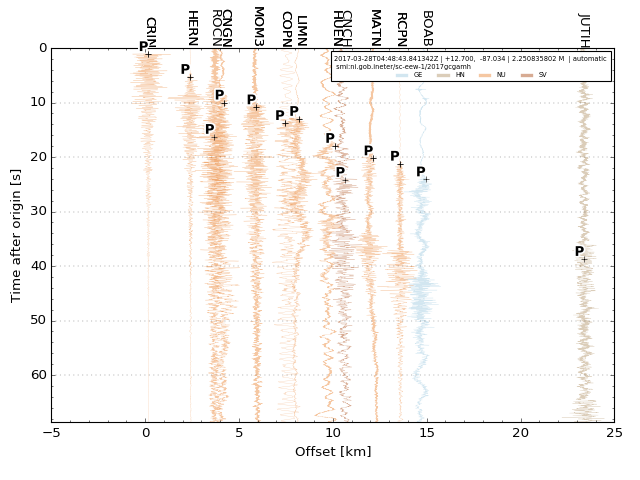

<IPython.core.display.Javascript object>


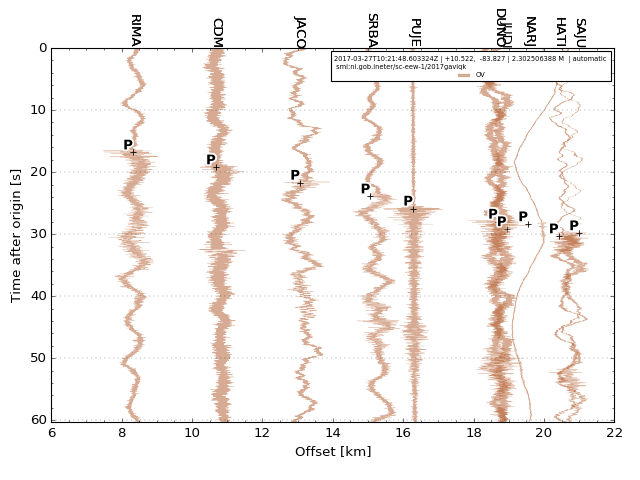

<IPython.core.display.Javascript object>


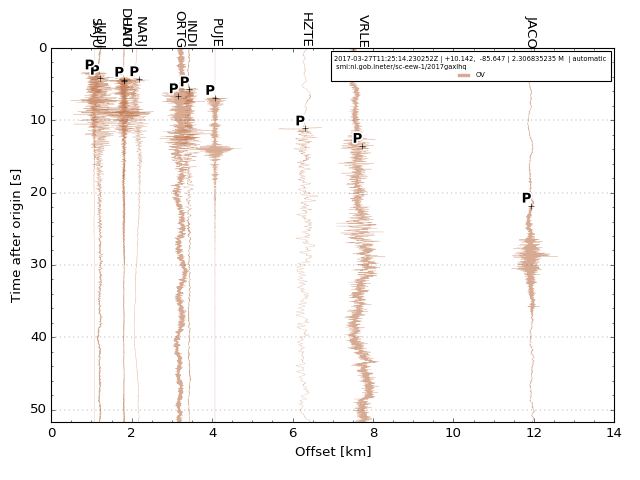

<IPython.core.display.Javascript object>


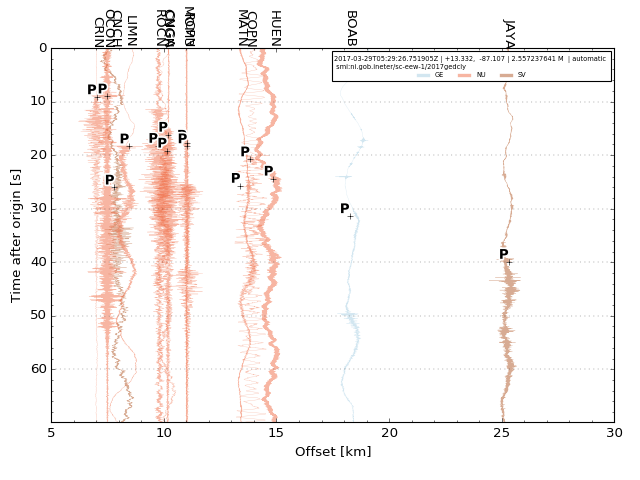

<IPython.core.display.Javascript object>


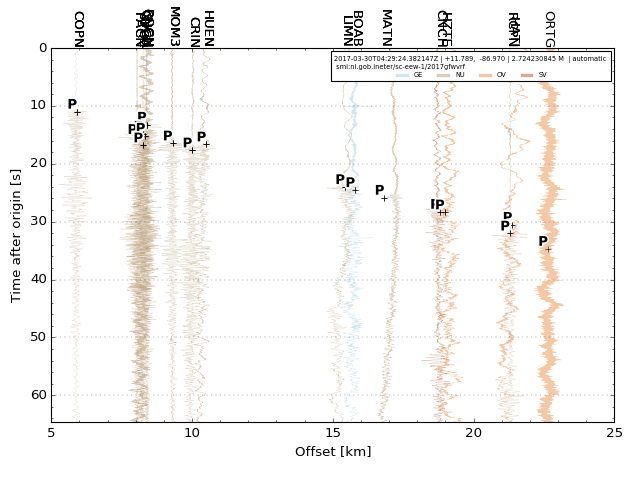

<IPython.core.display.Javascript object>


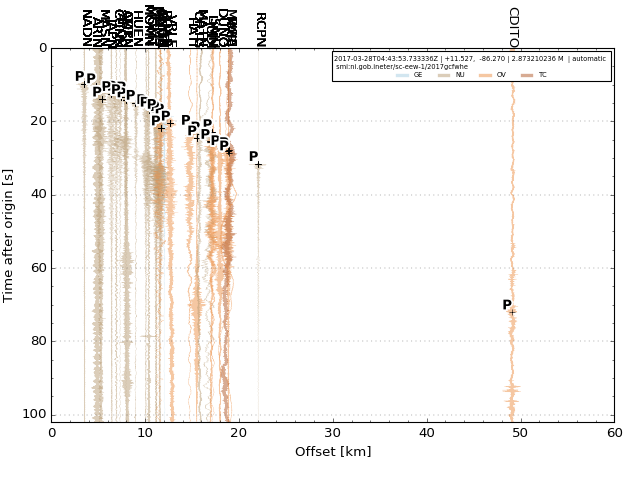

<IPython.core.display.Javascript object>


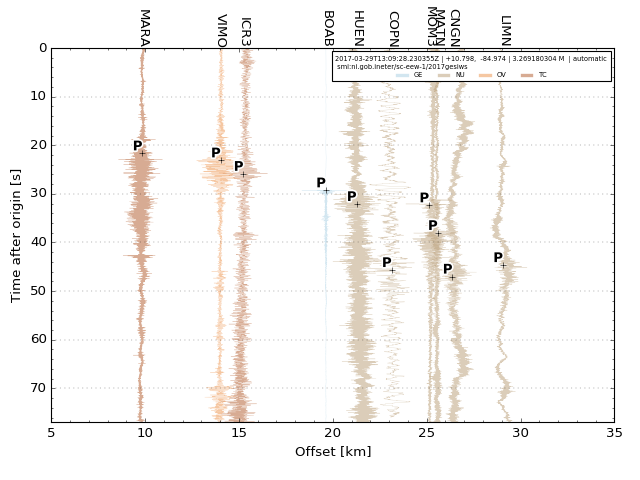

<IPython.core.display.Javascript object>


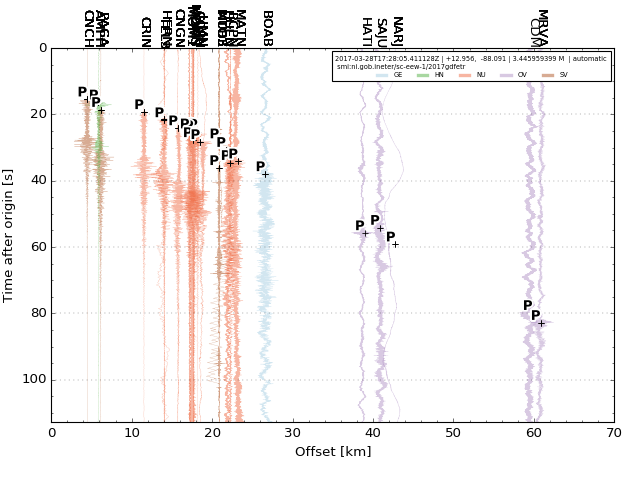

<IPython.core.display.Javascript object>


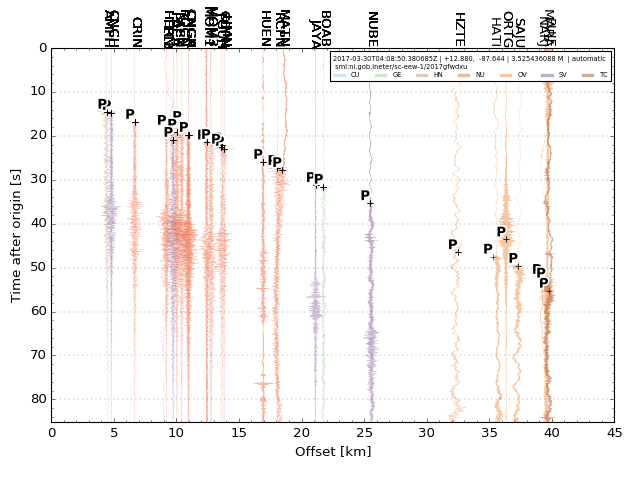

<IPython.core.display.Javascript object>


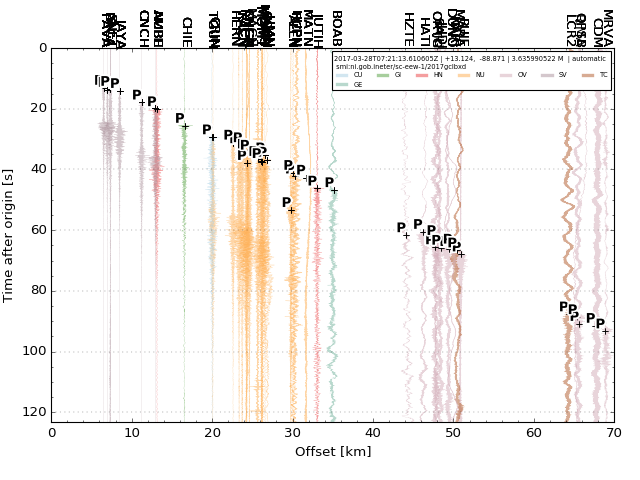

<IPython.core.display.Javascript object>


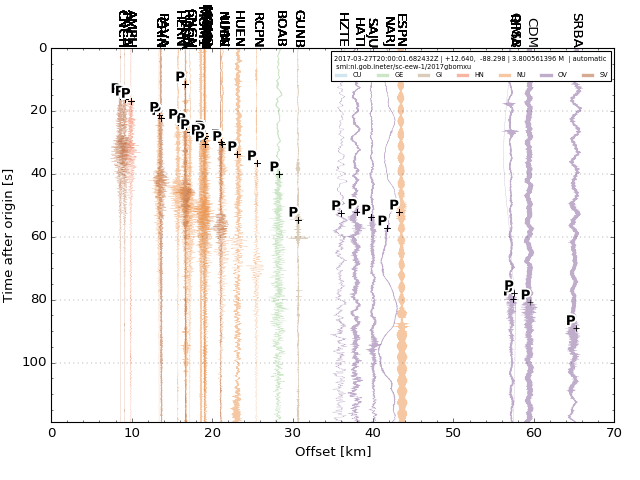

<IPython.core.display.Javascript object>


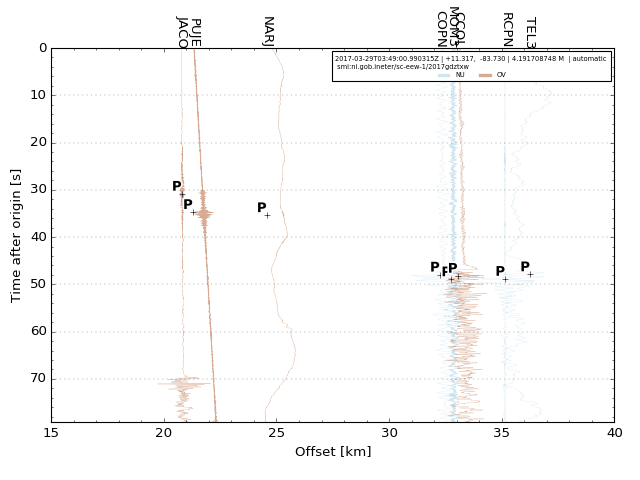

In [17]:
[print('scolv -E '+str(e.resource_id)) for e in falses_eew ]
falses_eew.plot_eventsections(client_eq)  

## Extra EEW missing in EAL

In [18]:
if len(missed_main)>0:
    fig = missed_main.plot(**map_specs)
print(missed_main)

0 Event(s) in Catalog:



###  Review of extra EEW

In [ ]:
[print('scolv -E '+str(e.resource_id)) for e in missed_main ] 
missed_main.plot_eventsections(client_eq)  

## How consistent is INETER EEW catalog
### How consistent and how fast are 1rst Mvs ?

<IPython.core.display.Javascript object>


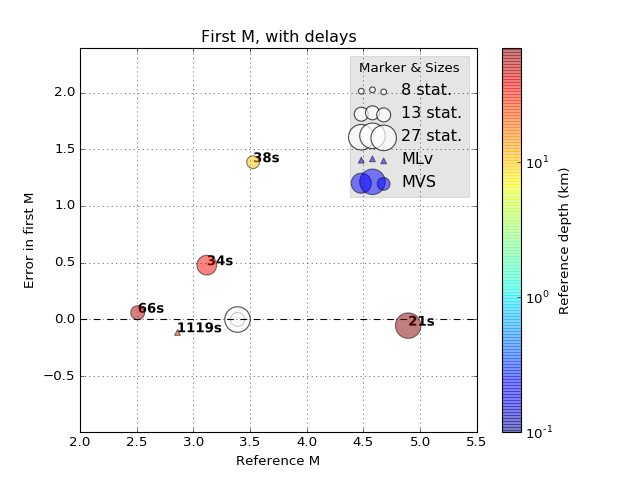

5 Event(s) in Catalog:
2017-03-27T18:45:42.399573Z | +11.889,  -86.646 | 2.813072664 M  | automatic
2017-03-28T22:41:11.848908Z | +11.276,  -86.441 | 2.93224233 M  | automatic
2017-03-27T17:22:04.225162Z | +12.103,  -86.932 | 3.160130808 M  | automatic
2017-03-29T22:24:52.040534Z | +11.183,  -87.016 | 3.403174609 M  | automatic
2017-03-29T16:59:09.938843Z | +11.884,  -86.643 | 5.135709594 M  | automatic


In [25]:
eewcat_checked.plot_Mfirst()

###  Review of erroneous EEM cases

In [34]:
for e in eewcat_checked :
    if abs(e.magnitudes[0].mag-e.magnitudes[-1].mag)>1  :
        print('scolv -E '+str(e.resource_id))
        ec = eewcat_checked.filter('time > '+str(e.preferred_origin().time-10),
                                   'time < '+str(e.preferred_origin().time+10))
        ec.plot_eventsections(client_eq)  

scolv -E smi:ni.gob.ineter/sc-eew-1/2017gfktrk


### How does the EEW perform ?

<IPython.core.display.Javascript object>


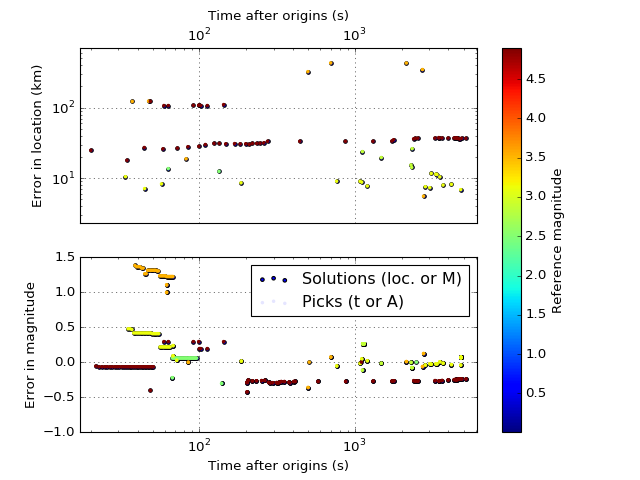

In [33]:
eewcat_checked.plot_eew()

###  Review of slow EEW cases

In [ ]:
for e in eewcat_checked :
    if abs(e.magnitudes[0].creation_info.creation_time-e.origins[-1].time)>120:
        print('scolv -E ',str(e.resource_id))
        ec = eewcat_checked.filter('time > '+str(e.preferred_origin().time-10),
                                   'time < '+str(e.preferred_origin().time+10))
        ec.plot_eventsections(client_eq)  